In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# dataset load
data = pd.read_csv("/home/dataset/complete_dataset.csv")
# data = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data["일시"] = pd.to_datetime(data["일시"])
data.index = data["일시"]
del data["일시"]
data.head()

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),평균 풍속(m/s),최다풍향(16방위),최소 상대습도(%),평균 상대습도(%),평균 현지기압(hPa),...,일 최심적설(cm),평균 전운량(1/10),평균 지면온도(°C),최저 초상온도(°C),PM-10,PM-2.5,o3,no2,co,so2
일시,,,,,,,,,,,,,,,,,,,,,
2018-04-01,15.6,11.7,18.5,0.00,0.0,1.5,200.0,50.0,68.8,1006.3,...,0.0,9.1,14.3,6.2,57.0,27.0,0.028,0.039,0.5,0.004
2018-04-02,18.4,14.9,23.7,0.00,0.0,1.9,230.0,41.0,64.0,1005.4,...,0.0,6.1,17.8,11.1,58.0,21.0,0.028,0.039,0.5,0.005
2018-04-03,17.8,14.9,21.2,2.92,0.1,2.1,230.0,50.0,72.9,1006.4,...,0.0,9.1,17.2,13.8,61.0,16.0,0.018,0.042,0.5,0.005
2018-04-04,13.4,9.5,18.2,6.50,18.5,1.9,90.0,40.0,67.0,1007.4,...,0.0,6.1,15.9,7.9,9.0,4.0,0.024,0.031,0.4,0.003
2018-04-05,7.6,6.7,9.5,19.67,10.5,2.0,90.0,61.0,90.6,1005.7,...,0.0,9.9,8.9,6.2,5.0,3.0,0.015,0.039,0.5,0.003


In [3]:
class StatefulLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.reset_state()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
    self.head = nn.Linear(hidden_size, output_size)

  def reset_state(self, state=None):
    self.state = state

  def forward(self, x):
    assert x.dim() == 2   # (sequence_length, input_size)
    if self.state is None:
      x, (hn, cn) = self.rnn(x)   # state will be set to be zeros by default
    else:
      x, (hn, cn) = self.rnn(x, self.state)   # pass the saved state
    # x.shape == (sequence_length, hidden_size)
    self.reset_state((hn.detach(), cn.detach()))   # save the state
    x = self.head(x)  # (sequence_length, hidden_size) -> (sequence_length, output_size)
    return x

  def predict(self, x0, steps, state=None):
    if state is not None:
      self.reset_state(state)
    output = []
    x = x0.reshape(1,-1)
    for i in range(steps): # 한 칸씩 옆으로 이동
      x = self.forward(x)
      output.append(x)
    return torch.concat(output, 0) #output의 맨 마지막 녀석들만 따오도록

In [4]:
tst_size = 200

data = data.dropna()

trn, tst = data[:-tst_size], data[-tst_size:]

scaler = MinMaxScaler()

trn_scaled, tst_scaled = trn.copy(), tst.copy()
trn_scaled = scaler.fit_transform(trn.to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(tst.to_numpy(dtype=np.float32))


In [5]:
batch_size = 64
trn_x = torch.tensor(trn.to_numpy(dtype=np.float32)[:-1]).split(batch_size)
trn_y = torch.tensor(trn.to_numpy(dtype=np.float32)[1:]).split(batch_size)

tst_y = torch.tensor(tst.to_numpy(dtype=np.float32))

trn_x[0].shape, trn_y[0].shape

(torch.Size([64, 22]), torch.Size([64, 22]))

In [50]:
trn_x[0]

tensor([[1.5600e+01, 1.1700e+01, 1.8500e+01,  ..., 3.9000e-02, 5.0000e-01,
         4.0000e-03],
        [1.8400e+01, 1.4900e+01, 2.3700e+01,  ..., 3.9000e-02, 5.0000e-01,
         5.0000e-03],
        [1.7800e+01, 1.4900e+01, 2.1200e+01,  ..., 4.2000e-02, 5.0000e-01,
         5.0000e-03],
        ...,
        [2.3800e+01, 1.7500e+01, 3.0200e+01,  ..., 5.0000e-02, 6.0000e-01,
         3.0000e-03],
        [2.3400e+01, 1.7600e+01, 3.0100e+01,  ..., 5.0000e-02, 5.0000e-01,
         5.0000e-03],
        [2.4000e+01, 1.6900e+01, 3.0800e+01,  ..., 3.7000e-02, 4.0000e-01,
         3.0000e-03]])

In [46]:
trn_y[0]

tensor([[1.8400e+01, 1.4900e+01, 2.3700e+01,  ..., 3.9000e-02, 5.0000e-01,
         5.0000e-03],
        [1.7800e+01, 1.4900e+01, 2.1200e+01,  ..., 4.2000e-02, 5.0000e-01,
         5.0000e-03],
        [1.3400e+01, 9.5000e+00, 1.8200e+01,  ..., 3.1000e-02, 4.0000e-01,
         3.0000e-03],
        ...,
        [2.3400e+01, 1.7600e+01, 3.0100e+01,  ..., 5.0000e-02, 5.0000e-01,
         5.0000e-03],
        [2.4000e+01, 1.6900e+01, 3.0800e+01,  ..., 3.7000e-02, 4.0000e-01,
         3.0000e-03],
        [2.2600e+01, 1.8900e+01, 2.7500e+01,  ..., 4.5000e-02, 5.0000e-01,
         5.0000e-03]])

In [107]:
rnn = StatefulLSTM(1, 64, 1, 3)
rnn.to(device)
target_column=17
optim = torch.optim.AdamW(rnn.parameters(), lr=1e-5)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  rnn.reset_state() # 각 에폭마다 state를 reset해주어야 함.
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x[:, 17:18].to(device), y[:, 17:18].to(device)
    optim.zero_grad()
    p = rnn(x)
    print(p.shape, y.shape)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    p = rnn.predict(y[-1:].to(device), len(tst_y)) # 마지막 1개를 넣어서 뒤에 20개를 예측
    tst_loss = F.mse_loss(p, tst_y[:, 17:18].to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1]) torch.Size([64, 1])


In [108]:
rnn.eval()
rnn.reset_state() # 각 에폭마다 state를 reset해주어야 함.
trn_loss = .0
save = []
for x, y in zip(trn_x, trn_y):
    x, y = x[:, 17:18].to(device), y[:, 17:18].to(device)
    p = rnn(x)
    save.append(p)
    

In [109]:
output = torch.concat(save, 0)
output.shape

torch.Size([1778, 1])

In [103]:
def mape(input, target):
  return (np.abs(input - target)/target).mean() * 100

def mae(input, target):
  return np.abs(input - target).mean()

def mae(input, target):
  return np.abs(input - target).mean()

In [19]:
scaler.inverse_transform(p.cpu()).shape

(200, 22)

In [21]:
p.shape

torch.Size([200, 22])

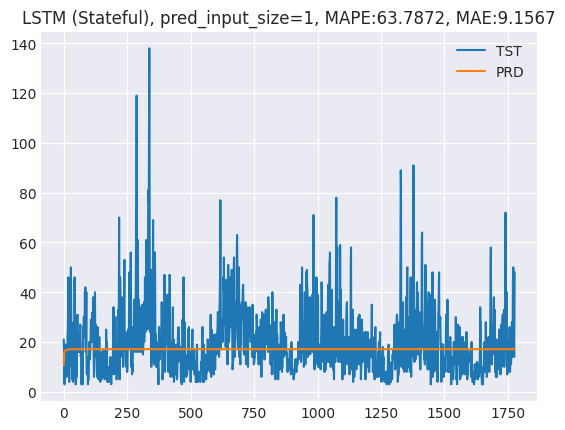

In [110]:
# prd = scaler.inverse_transform(p.cpu())[:, 17:18]
prd = output.detach().cpu()
tst_data = trn.iloc[:, 17:18].to_numpy()
plt.title(f"LSTM (Stateful), pred_input_size=1, MAPE:{mape(prd,tst_data):.4f}, MAE:{mae(prd,tst_data):.4f}")
plt.plot(tst_data, label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [63]:
# F.mse_loss(torch.from_numpy(prd),torch.from_numpy(tst_data))
F.mse_loss(prd,torch.from_numpy(tst_data))

/tmp/ipykernel_521108/1678888442.py:2: UserWarning: Using a target size (torch.Size([1779])) that is different to the input size (torch.Size([1778, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(prd,torch.from_numpy(tst_data))


tensor(176.8370, dtype=torch.float64)

1. 이대로 일단 합친다 
2. 코드 상의 문제인지 한번 더 확인한다 -> 선택!